In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fedesoriano/cifar100")

print("Path to dataset files:", path)

100%|██████████| 161M/161M [00:04<00:00, 35.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fedesoriano/cifar100/versions/1


In [ ]:
import shutil

In [ ]:
shutil.move(path, "/content/Data") #Change after the comma to desired destination

'/content/Data/1'

In [ ]:
import pickle

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
metadata_path = '/content/Data/1/meta' # change this path
metadata = unpickle(metadata_path)
superclass_dict = dict(list(enumerate(metadata[b'coarse_label_names'])))

In [ ]:
data_pre_path = '/content/Data/1/' # change this path
# File paths
data_train_path = data_pre_path + 'train'
data_test_path = data_pre_path + 'test'
# Read dictionary
data_train_dict = unpickle(data_train_path)
data_test_dict = unpickle(data_test_path)
# Get data (change the labels type to coarse_labels if you want to use the 20 classes)
data_train = data_train_dict[b'data']
label_train = np.array(data_train_dict[b'fine_labels'])
data_test = data_test_dict[b'data']
label_test = np.array(data_test_dict[b'fine_labels'])

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import models
from tqdm import tqdm
import numpy as np
import os

In [ ]:
data_train.shape

(50000, 3072)

In [ ]:
import numpy as np
import random
from PIL import Image, ImageDraw
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader, Dataset

In [ ]:
# Reshape the data to 3x32x32 (CIFAR format)
def reshape_data(data):
    # Reshape the data from (num_samples, 3072) to (num_samples, 3, 32, 32)
    return data.reshape(-1, 3, 32, 32).astype(np.uint8)

In [ ]:
data_train_new = reshape_data(data_train)
data_test_new = reshape_data(data_test)

In [ ]:
data_train_new.shape

(50000, 3, 32, 32)

In [ ]:
baseline_images=np.array(data_train_new)

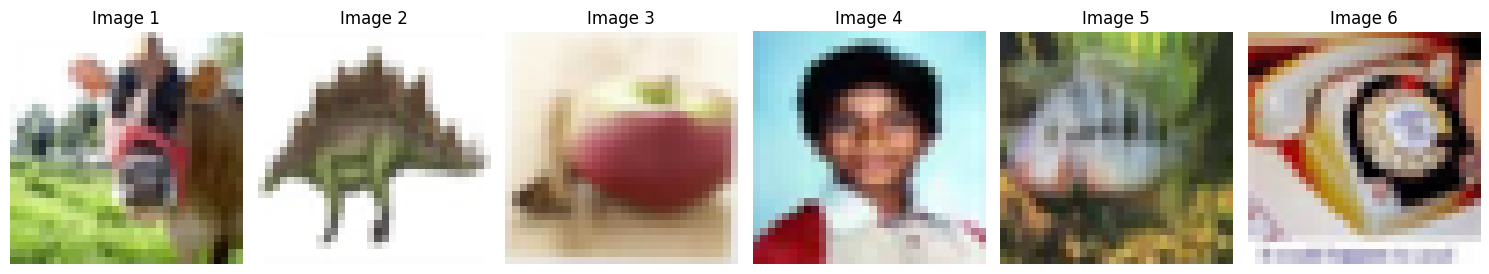

In [ ]:
# Number of images to display
num_images_to_show = 6

# Set up the plot grid
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 5))

# Loop through and display a few augmented images
for i in range(num_images_to_show):
    # Get the i-th augmented image
    image = baseline_images[i]

    image = image.transpose(1, 2, 0)
    # Show the image
    axes[i].imshow(image)
    axes[i].axis('off')  # Hide axis for better visualization
    axes[i].set_title(f"Image {i+1}")

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
def add_black_squares(image, num_squares=7, square_size_range=(3, 6)):
    """
    Adds black squares to the image to occlude parts of it.

    Parameters:
    - image: PIL Image object
    - num_squares: Number of squares to add to the image
    - square_size_range: Tuple (min_size, max_size) for random square sizes

    Returns:
    - Augmented PIL Image with black squares
    """
    width, height = image.size



    draw = ImageDraw.Draw(image)

    for _ in range(num_squares):
        # Randomly determine the size of the square
        square_size = random.randint(square_size_range[0], square_size_range[1])

        # Randomly determine the top-left corner of the square
        top_left_x = random.randint(0, width - square_size)
        top_left_y = random.randint(0, height - square_size)

        # Define the bottom-right corner of the square
        bottom_right_x = top_left_x + square_size
        bottom_right_y = top_left_y + square_size

        # Draw a black square
        draw.rectangle([top_left_x, top_left_y, bottom_right_x, bottom_right_y], fill="black")

    return image

In [ ]:
# Convert data to PIL images for the Occlusion augmentation
train_images = [Image.fromarray(image.transpose(1, 2, 0)) for image in data_train_new]
#test_images = [Image.fromarray(image.transpose(1, 2, 0)) for image in data_test_new]

In [ ]:
augmented_train_images = []

# Loop over each training image
for image in train_images:
    # Apply the add_black_squares function to each image
    augmented_image = add_black_squares(image)

    #half the time dont augment the imgage
    x = random.randint(1,10)
    if x<=5:
      # Store the augmented image
      augmented_train_images.append(augmented_image)
    else:
      augmented_train_images.append(image)

# Convert the list of augmented images back into a numpy array
augmented_train_images = np.array(augmented_train_images)

In [ ]:
augmented_train_images.shape

(50000, 32, 32, 3)

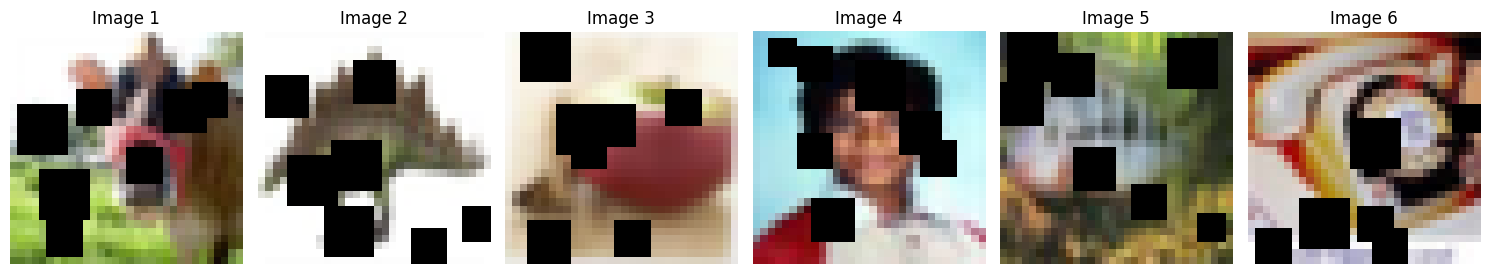

In [ ]:
# Number of images to display
num_images_to_show = 6

# Set up the plot grid
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 5))

# Loop through and display a few augmented images
for i in range(num_images_to_show):
    # Get the i-th augmented image
    image = augmented_train_images[i]


    # Show the image
    axes[i].imshow(image)
    axes[i].axis('off')  # Hide axis for better visualization
    axes[i].set_title(f"Image {i+1}")

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),        # Random horizontal flip
    transforms.RandomRotation(15),            # Random rotation up to 15 degrees
    transforms.RandomCrop(32, padding=4),    # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Random color jitter
    transforms.ToTensor(),                    # Convert image to Tensor
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [0, 1] range
])

# Apply the augmentations on each image
train_images_augmented = [transform_train(Image.fromarray(image)) for image in augmented_train_images]

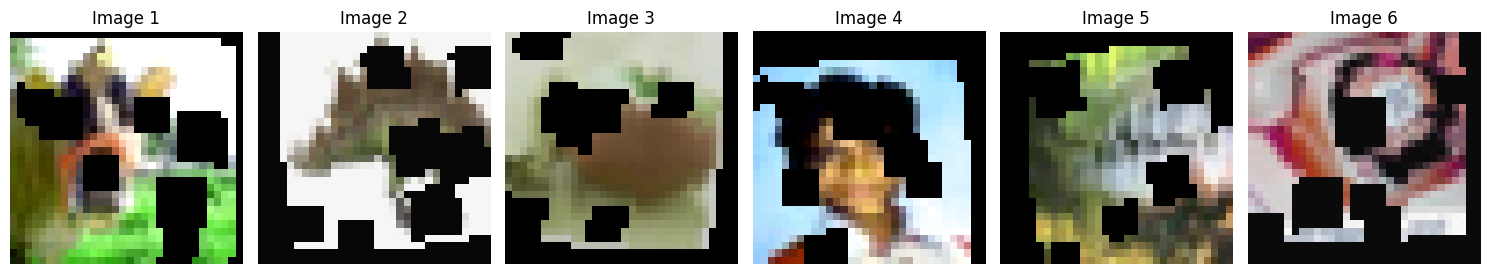

In [ ]:
# Number of images to display
num_images_to_show = 6

# Set up the plot grid
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 5))

# Loop through and display a few augmented images
for i in range(num_images_to_show):
    # Get the i-th augmented image
    image = train_images_augmented[i]

    image_np = image.permute(1, 2, 0).numpy()

    # Show the image
    axes[i].imshow(image_np)
    axes[i].axis('off')  # Hide axis for better visualization
    axes[i].set_title(f"Image {i+1}")

# Show the plot
plt.tight_layout()
plt.show()